In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from alive_progress import alive_it

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_regression

In [16]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests

from bs4 import BeautifulSoup
from datetime import datetime, timedelta

def get_nasdaq_symbols():
    url = "https://en.wikipedia.org/wiki/Nasdaq-100"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    symbols = [row.find_all('td')[1].text for row in table.find_all('tr')[1:]]
    return symbols

def get_ftse_symbols():
    url = "https://en.wikipedia.org/wiki/FTSE_100_Index"
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    table = soup.find('table', {'id': 'constituents'})
    symbols = []
    for row in table.find_all('tr')[1:]:
        ticker = row.find_all('td')[1].text.strip()
        if ticker.endswith('.'):
            symbols.append(ticker + 'L')
        elif ticker.endswith('ICG'):
            pass
        else:
            symbols.append(ticker + '.L')
    return symbols

def get_sgx_symbols():
    return ['C6L.SI', 'D05.SI', 'O39.SI', 'Z74.SI', 'U11.SI', 'G13.SI', 'F34.SI', 'Y92.SI', 'S68.SI', 'A17U.SI']

def get_stock_data(ticker, end_date, days_back=60, interval="60m"):
    if isinstance(end_date, str):
        end_date = datetime.strptime(end_date, '%Y-%m-%d')
    start_date = end_date - timedelta(days=days_back)
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date, interval=interval)
        if df.empty:
            return None
        return df
    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None

def calculate_metrics(df, market='NASDAQ'):
    trading_days_per_year = 252
    if market == 'NASDAQ':
        hours_per_day = 6.5  # NASDAQ trading hours: 9:30 AM to 4:00 PM 
    elif market == 'FTSE':
        hours_per_day = 8.5  # FTSE trading hours: 8:00 AM to 4:30 PM 
    elif market == 'SGX':
        hours_per_day = 8    # SGX trading hours: 9:00 AM to 5:00 PM 

    # log return for each period (hourly)
    df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))
    # total return from the beginning of the period
    df['Cumulative_Return'] = (df['Close'] / df['Close'].iloc[0]) - 1
    # annualized volatility using a 5-day rolling window
    df['Volatility'] = df['Log_Return'].rolling(window=int(hours_per_day * 5)).std() * np.sqrt(hours_per_day * trading_days_per_year)
    # annualized Sharpe ratio
    df['Sharpe'] = (df['Log_Return'].mean() * (hours_per_day * trading_days_per_year)) / (df['Log_Return'].std() * np.sqrt(hours_per_day * trading_days_per_year))
    # 5-day moving average of trading volume
    df['Volume_MA'] = df['Volume'].rolling(window=int(hours_per_day * 5)).mean()
    # 5-day price momentum
    df['Momentum'] = df['Close'] / df['Close'].shift(int(hours_per_day * 5)) - 1
    return df

def score_stock(ticker, market, end_date, days_back=60, allow_short=False):
    df = get_stock_data(ticker, end_date, days_back)
    if df is None or df.empty or len(df) < int(6.5 * 5):
        return None
    
    try:
        df = calculate_metrics(df, market)
        volatility_score = df['Volatility'].mean()
        liquidity_score = (df['Volume'] / df['Volume_MA']).mean()
        momentum_score = df['Momentum'].mean() if allow_short else max(df['Momentum'].mean(), 0)
        sharpe_score = df['Sharpe'].mean() if allow_short else max(df['Sharpe'].mean(), 0)
        return_score = df['Cumulative_Return'].iloc[-1] 
        
        # please play around with the scores below
        if allow_short:
            total_score = (volatility_score * 0.4 +    # higher vol as it provides profit opp in both directions
                        liquidity_score * 0.1 +        # liquid positions to enter and exit
                        np.abs(momentum_score) * 0.1 +
                        np.abs(return_score) * 0.3)     # abs(return) to see if the market moves

        else:
            total_score = (return_score * 0.3 +         # more weight to higher returns
                        volatility_score * 0.35 + 
                        liquidity_score * 0.15 +        # liquid positions to enter and exit
                        momentum_score * 0.1 +
                        sharpe_score * 0.1)             # risk adjusted returns
        return total_score
    
    except Exception as e:
        print(f"Error calculating score for {ticker}: {e}")
        return None

def get_top_stocks(tickers, markets, end_date, days_back=60, n=30, allow_short=False):
    scores = {}
    for ticker, market in zip(tickers, markets):
        score = score_stock(ticker, market, end_date, days_back, allow_short)
        if score is not None:
            scores[ticker] = score
    
    top_stocks = sorted(scores, key=scores.get, reverse=True)[:n]
    return top_stocks

nasdaq_symbols = get_nasdaq_symbols()
ftse_symbols = get_ftse_symbols()
sgx_symbols = get_sgx_symbols()
all_symbols = nasdaq_symbols + ftse_symbols + sgx_symbols
all_markets = ['NASDAQ'] * len(nasdaq_symbols) + ['FTSE'] * len(ftse_symbols) + ['SGX'] * len(sgx_symbols)

end_date = "2023-12-31"
days_back = 360

top_stocks_long = get_top_stocks(all_symbols, all_markets, end_date, days_back, n=30, allow_short=False)
top_stocks_long_short = get_top_stocks(all_symbols, all_markets, end_date, days_back, n=30, allow_short=True)

print("Top 30 stocks (Long-Only Strategy):")
for i, stock in enumerate(top_stocks_long, 1):
    print(f"{i}. {stock}")

print("\nTop 30 stocks (Long-Short Strategy):")
for i, stock in enumerate(top_stocks_long_short, 1):
    print(f"{i}. {stock}")

pd.DataFrame({'Rank': range(1, 31), 'Ticker': top_stocks_long}).to_csv('stock-selection/top_30_stocks_long_only.csv', index=False)
pd.DataFrame({'Rank': range(1, 31), 'Ticker': top_stocks_long_short}).to_csv('stock-selection/top_30_stocks_long_short.csv', index=False)

print("\nResults saved to 'top_30_stocks_long_only.csv' and 'top_30_stocks_long_short.csv'")

if top_stocks_long:
    top_stock = top_stocks_long[0]
    df = get_stock_data(top_stock, end_date, days_back)
    if df is not None:
        df = calculate_metrics(df)
        print(f"\nDetailed metrics for top stock (Long-Only Strategy) {top_stock}:")
        print(f"Final Close Price: {df['Close'].iloc[-1]:.2f}")
        print(f"60-day Return: {df['Cumulative_Return'].iloc[-1] * 100:.2f}%")
        print(f"Average Hourly Volatility: {df['Volatility'].mean():.4f}")
        print(f"Average Sharpe Ratio: {df['Sharpe'].mean():.4f}")
        print(f"Average Hourly Volume: {df['Volume'].mean():.0f}")

Top 30 stocks (Long-Only Strategy):
1. SMCI
2. NVDA
3. RR.L
4. META
5. CRWD
6. AMD
7. TSLA
8. MDB
9. PANW
10. AVGO
11. ZS
12. DASH
13. MKS.L
14. III.L
15. TEAM
16. LRCX
17. MELI
18. INTC
19. DDOG
20. AMZN
21. ADBE
22. CDNS
23. MSFT
24. BKNG
25. WDAY
26. CPRT
27. MRVL
28. INTU
29. SNPS
30. TTD

Top 30 stocks (Long-Short Strategy):
1. SMCI
2. NVDA
3. RR.L
4. META
5. CRWD
6. MDB
7. TSLA
8. AMD
9. ZS
10. PANW
11. DASH
12. TEAM
13. DDOG
14. AVGO
15. MKS.L
16. MELI
17. INTC
18. LRCX
19. TTD
20. MRVL
21. AMZN
22. PDD
23. ADBE
24. WDAY
25. ABNB
26. III.L
27. CDNS
28. AMAT
29. MRNA
30. MU

Results saved to 'top_30_stocks_long_only.csv' and 'top_30_stocks_long_short.csv'

Detailed metrics for top stock (Long-Only Strategy) SMCI:
Final Close Price: 284.26
60-day Return: 250.61%
Average Hourly Volatility: 0.6678
Average Sharpe Ratio: 1.6242
Average Hourly Volume: 355714


In [3]:
stocks = top_stocks_long_short[:10]
stocks

['SMCI', 'NVDA', 'RR.L', 'META', 'CRWD', 'MDB', 'TSLA', 'AMD', 'ZS', 'PANW']

In [4]:
data = yf.download(stocks[0],'2023-01-01','2024-08-01', interval='1h')
data

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2023-01-03 09:30:00-05:00,83.080002,85.250000,83.000000,83.754997,83.754997,221397
2023-01-03 10:30:00-05:00,83.790001,83.949997,82.209999,82.250000,82.250000,114501
2023-01-03 11:30:00-05:00,82.300003,83.440002,81.940002,83.396500,83.396500,95571
2023-01-03 12:30:00-05:00,83.440002,84.379997,83.339996,84.349998,84.349998,74348
2023-01-03 13:30:00-05:00,84.209999,84.209999,83.013702,83.029999,83.029999,60236
...,...,...,...,...,...,...
2024-07-26 11:30:00-04:00,709.000000,717.229980,706.599976,715.479980,715.479980,620636
2024-07-26 12:30:00-04:00,716.250000,723.039978,715.640198,720.960022,720.960022,443352
2024-07-26 13:30:00-04:00,720.330017,720.919983,711.190002,715.859985,715.859985,387534


In [5]:
def insert_ema_column(df, hours, column_to_ema, ema_column_name):
    side_df = df.copy()
    multiplier = 2 / (1 + hours)
    side_df.loc[hours, ema_column_name] = side_df.iloc[:hours][column_to_ema].mean()
    for day in range(hours + 1, len(side_df)):
        side_df.loc[day, ema_column_name] = side_df.loc[day - 1, ema_column_name] * (1 - multiplier) + side_df.loc[day, column_to_ema] * multiplier

    side_df[ema_column_name] = (side_df[column_to_ema] / side_df[ema_column_name] - 1).clip(-1, 1)
    return side_df

def insert_sma_column(df, hours, column_to_sma, sma_column_name):
    side_df = df.copy()
    side_df[sma_column_name] = side_df[column_to_sma].rolling(hours).mean()

    side_df[sma_column_name] = (side_df[column_to_sma] / side_df[sma_column_name] - 1).clip(-1, 1)
    
    return side_df

def insert_vwap_column(df, hours, vwap_column_name):
    side_df = df.copy()
    side_df[vwap_column_name] = side_df['Close'] * side_df['Volume']
    side_df[vwap_column_name] = side_df[vwap_column_name].rolling(hours).sum() / side_df['Volume'].rolling(hours).sum()

    side_df[vwap_column_name] = (side_df['Close'] / side_df[vwap_column_name] - 1).clip(-1, 1)
    
    return side_df

def insert_stddev_column(df, hours, stddev_column_name):
    side_df = df.copy()
    side_df[stddev_column_name] = side_df['Close'].rolling(hours).std()
    
    return side_df

def insert_fama_french_column(df):

    ff_factors = pd.read_csv('Data/famafrench_daily_factor.csv')
    ff_factors.drop(['Date_str'], axis=1, inplace=True)
    ff_factors = ff_factors.set_index('Date')
    ff_factors.index = pd.to_datetime(ff_factors.index)
    
    fdf = ff_factors.reset_index()
    fdf = fdf[['Date', 'Mkt-RF']].rename(columns={'Mkt-RF': 'FamaFrenchMktReturns'})
    fdf = fdf[
        fdf['Date'] >= '2023-01-01'
    ]
    fdf['Date'] = pd.to_datetime(fdf['Date'])
    
    side_df = df.copy()
    side_df = side_df.reset_index(drop=True)
    side_df['Date'] = pd.to_datetime(side_df['Datetime'].dt.date)
    side_df = side_df.merge(fdf, how='left', on='Date')
    side_df = side_df.drop(['Date'], axis=1)
    side_df['FamaFrenchMktReturns'] = side_df['FamaFrenchMktReturns'].ffill()
    return side_df

In [39]:
df = data.copy()
df = df.reset_index()

trading_days_per_year = 252
hours_per_day = 6.5

# log return for each period (hourly)
df['Log_Return'] = np.log(df['Close'] / df['Close'].shift(1))

hours_gridsearch = [2 ** i for i in range(1, 9)]

for index, hour in enumerate(hours_gridsearch):
    ema_column_name = f"EMAVolumeDiff{hour}"
    df = insert_ema_column(df, hour, 'Volume', ema_column_name)

    sma_column_name = f"SMAVolumeDiff{hour}"
    df = insert_sma_column(df, hour, 'Volume', sma_column_name)

    ema_column_name = f"EMACloseDiff{hour}"
    df = insert_ema_column(df, hour, 'Close', ema_column_name)
    
    sma_column_name = f"SMACloseDiff{hour}"
    df = insert_sma_column(df, hour, 'Close', sma_column_name)

    vwap_column_name = f"VWAP{hour}"
    df = insert_vwap_column(df, hour, vwap_column_name)

    stddev_column_name = f"VolatilityStdDev{hour}"
    df = insert_stddev_column(df, hour, stddev_column_name)
    
    # annualized volatility using a 5-day rolling window
    df[f'Volatility{hour}'] = df['Log_Return'].rolling(window=hour).std() * np.sqrt(hours_per_day * trading_days_per_year)
    
    # momentum from t-x hour
    df[f'Momentum{hour}'] = (df['Close'] / df['Close'].shift(hour)).clip(-1, 1)

df['PriceVolatilityHourly'] = ((df['High'] - df['Low']) - 1).clip(-1, 1)

### brb fixing normalization
for index, hour in enumerate(hours_gridsearch):
    if index <= 1:
        continue

    longer = f'EMACloseDiff{hour}'
    shorter = f'EMACloseDiff{hours_gridsearch[index - 1]}'
    signal = f'EMACloseDiff{hours_gridsearch[index - 2]}'
    df[f'MACD{hour}'] = (df[longer] - df[shorter]) / df[signal]

df = insert_fama_french_column(df)
df["Log_Return_shift"] = df["Log_Return"].shift(-1)
df = df.dropna().reset_index(drop=True)
df

,Datetime,Open,High,Low,Close,Adj Close,Volume,Log_Return,EMAVolumeDiff2,SMAVolumeDiff2,...,Momentum256,PriceVolatilityHourly,MACD8,MACD16,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns,Log_Return_shift
0,2023-02-24 13:30:00-05:00,97.259903,97.969902,96.809998,97.889999,97.889999,162598,0.007074,-0.011522,0.169707,...,1.000000,0.159904,4.138951,2.046955,0.649950,0.389898,0.559972,0.942536,-1.09,-0.005634
1,2023-02-24 14:30:00-05:00,97.891098,98.360001,97.000000,97.339996,97.339996,299026,-0.005634,0.176426,0.295539,...,1.000000,0.360001,-14.967468,7.645914,1.188432,0.541187,0.671433,1.054185,-1.09,0.008491
2,2023-02-24 15:30:00-05:00,97.305000,98.190002,97.129997,98.169998,98.169998,262724,0.008491,0.010957,-0.064623,...,1.000000,0.060005,4.233344,2.981742,1.037436,0.525654,0.625907,0.973667,-1.09,0.047640
3,2023-02-27 09:30:00-05:00,98.860001,103.980003,98.699997,102.959999,102.959999,684667,0.047640,0.260734,0.445374,...,1.000000,1.000000,1.130377,0.774288,0.448448,0.303530,0.379541,0.628150,0.31,-0.001528
4,2023-02-27 10:30:00-05:00,102.919998,103.839996,101.889999,102.802803,102.802803,384289,-0.001528,-0.121055,-0.281001,...,1.000000,0.949997,4.010681,1.483437,0.677087,0.389404,0.427139,0.663667,0.31,-0.003828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,2024-07-26 10:30:00-04:00,711.299988,714.989990,703.000000,708.609985,708.609985,525669,-0.003859,-0.298183,-0.489866,...,0.917889,1.000000,-5.696568,-9.650752,42.524351,2.608505,0.714168,0.208965,0.68,0.009648
2478,2024-07-26 11:30:00-04:00,709.000000,717.229980,706.599976,715.479980,715.479980,620636,0.009648,-0.064501,0.082846,...,0.936259,1.000000,0.044289,-1.933203,-4.542280,7.044801,0.961897,0.248630,0.68,0.007630
2479,2024-07-26 12:30:00-04:00,716.250000,723.039978,715.640198,720.960022,720.960022,443352,0.007630,-0.141972,-0.166622,...,0.945447,1.000000,0.740714,-1.166260,-2.621058,-34.301592,1.301495,0.291306,0.68,-0.007099
2480,2024-07-26 13:30:00-04:00,720.330017,720.919983,711.190002,715.859985,715.859985,387534,-0.007099,-0.099999,-0.067179,...,0.955914,1.000000,-2.043687,-9.287794,-8.637522,8.380698,1.125260,0.281581,0.68,-0.001370


In [40]:
target = "Log_Return_shift"
features = df.columns[8:-1]
len(features)

72

In [41]:
X = df[features]
y = df[target]
X

,EMAVolumeDiff2,SMAVolumeDiff2,EMACloseDiff2,SMACloseDiff2,VWAP2,VolatilityStdDev2,Volatility2,Momentum2,EMAVolumeDiff4,SMAVolumeDiff4,...,Volatility256,Momentum256,PriceVolatilityHourly,MACD8,MACD16,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns
0,-0.011522,0.169707,0.003349,0.003537,0.002935,0.487905,0.007454,1.000000,-0.163512,-0.153437,...,0.728899,1.000000,0.159904,4.138951,2.046955,0.649950,0.389898,0.559972,0.942536,-1.09
1,0.176426,0.295539,-0.000764,-0.002817,-0.001986,0.388911,0.363684,1.000000,0.265775,0.422238,...,0.727519,1.000000,0.360001,-14.967468,7.645914,1.188432,0.541187,0.671433,1.054185,-1.09
2,0.010957,-0.064623,0.002572,0.004245,0.004521,0.586900,0.404235,1.000000,0.064379,0.251417,...,0.727021,1.000000,0.060005,4.233344,2.981742,1.037436,0.525654,0.625907,0.973667,-1.09
3,0.260734,0.445374,0.016594,0.023815,0.013070,3.387042,1.120379,1.000000,0.622562,0.943676,...,0.736192,1.000000,1.000000,1.130377,0.774288,0.448448,0.303530,0.379541,0.628150,0.31
4,-0.121055,-0.281001,0.004964,-0.000764,-0.000978,0.111154,1.407094,1.000000,-0.055559,-0.057368,...,0.735016,1.000000,0.949997,4.010681,1.483437,0.677087,0.389404,0.427139,0.663667,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2477,-0.298183,-0.489866,0.000421,-0.001930,-0.002872,1.937466,0.725292,1.000000,-0.341225,-0.325651,...,0.665361,0.917889,1.000000,-5.696568,-9.650752,42.524351,2.608505,0.714168,0.208965,0.68
2478,-0.064501,0.082846,0.003351,0.004824,0.004423,4.857820,0.386563,1.000000,-0.146333,-0.218178,...,0.665367,0.936259,1.000000,0.044289,-1.933203,-4.542280,7.044801,0.961897,0.248630,0.68
2479,-0.141972,-0.166622,0.003652,0.003815,0.004454,3.874975,0.057759,1.000000,-0.277405,-0.432490,...,0.665649,0.945447,1.000000,0.740714,-1.166260,-2.621058,-34.301592,1.301495,0.291306,0.68
2480,-0.099999,-0.067179,-0.001152,-0.003550,-0.003787,3.606270,0.421522,1.000000,-0.259225,-0.215991,...,0.664329,0.955914,1.000000,-2.043687,-9.287794,-8.637522,8.380698,1.125260,0.281581,0.68


In [42]:
train_size, val_size, test_size = 0.89, 0.01, 0.1
train_size, val_size, test_size = int(len(X) * train_size), int(len(X) * val_size), int(len(X) * test_size)
X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:].to_numpy()
X_train

,EMAVolumeDiff2,SMAVolumeDiff2,EMACloseDiff2,SMACloseDiff2,VWAP2,VolatilityStdDev2,Volatility2,Momentum2,EMAVolumeDiff4,SMAVolumeDiff4,...,Volatility256,Momentum256,PriceVolatilityHourly,MACD8,MACD16,MACD32,MACD64,MACD128,MACD256,FamaFrenchMktReturns
0,-0.011522,0.169707,0.003349,0.003537,0.002935,0.487905,0.007454,1.000000,-0.163512,-0.153437,...,0.728899,1.0,0.159904,4.138951,2.046955,0.649950,0.389898,0.559972,0.942536,-1.09
1,0.176426,0.295539,-0.000764,-0.002817,-0.001986,0.388911,0.363684,1.000000,0.265775,0.422238,...,0.727519,1.0,0.360001,-14.967468,7.645914,1.188432,0.541187,0.671433,1.054185,-1.09
2,0.010957,-0.064623,0.002572,0.004245,0.004521,0.586900,0.404235,1.000000,0.064379,0.251417,...,0.727021,1.0,0.060005,4.233344,2.981742,1.037436,0.525654,0.625907,0.973667,-1.09
3,0.260734,0.445374,0.016594,0.023815,0.013070,3.387042,1.120379,1.000000,0.622562,0.943676,...,0.736192,1.0,1.000000,1.130377,0.774288,0.448448,0.303530,0.379541,0.628150,0.31
4,-0.121055,-0.281001,0.004964,-0.000764,-0.000978,0.111154,1.407094,1.000000,-0.055559,-0.057368,...,0.735016,1.0,0.949997,4.010681,1.483437,0.677087,0.389404,0.427139,0.663667,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980,-0.072195,0.029135,-0.000435,0.000214,0.000207,0.272761,0.126978,0.996424,-0.274115,-0.264802,...,1.115041,1.0,1.000000,13.842534,1.245883,0.967081,1.537298,0.838726,-0.833249,-1.53
1981,0.196251,0.359460,-0.003068,-0.004378,-0.002808,5.564927,0.262789,0.991707,0.266688,0.548407,...,1.113554,1.0,1.000000,2.230097,0.784373,0.698068,1.084652,0.664141,-0.702745,-1.53
1982,-0.026932,-0.128760,0.000603,0.002441,0.002756,3.097131,0.390277,0.996134,-0.013500,0.148798,...,1.111206,1.0,1.000000,-9.639911,4.028314,1.399038,1.629353,0.860177,-0.783084,-1.53
1983,0.318517,0.577449,0.009889,0.014605,0.006120,18.851361,0.696302,1.000000,0.776447,1.000000,...,1.113428,1.0,1.000000,0.044465,-0.192427,-0.526502,-1.565988,-4.288572,-2.150689,-1.29


In [43]:
# Initialize transformations
# Important note: do standard scaling first before PCA
scaler = StandardScaler()
selector = SelectKBest(f_regression, k=10)
pca = PCA(n_components = 0.95)

# Fit the scaler on the training data and transform the training data
X_train = scaler.fit_transform(X_train)
X_train = selector.fit_transform(X_train, y_train)
X_train = pca.fit_transform(X_train)

# Transform the validation data
X_val = scaler.transform(X_val)
X_val = selector.transform(X_val)
X_val = pca.transform(X_val)

# Transform the test data
X_test = scaler.transform(X_test)
X_test = selector.transform(X_test)
X_test = pca.transform(X_test)

cols_idxs = selector.get_support(indices=True)
features_df_new = X[:train_size].iloc[:,cols_idxs]
features_df_new

,EMACloseDiff2,SMACloseDiff2,EMACloseDiff4,SMACloseDiff4,SMACloseDiff8,VolatilityStdDev8,VolatilityStdDev16,PriceVolatilityHourly,MACD8,FamaFrenchMktReturns
0,0.003349,0.003537,0.009981,0.008925,0.023090,1.544274,4.005828,0.159904,4.138951,-1.09
1,-0.000764,-0.002817,0.002579,0.001003,0.012895,1.470795,3.881172,0.360001,-14.967468,-1.09
2,0.002572,0.004245,0.006647,0.005325,0.015942,1.337311,3.635164,0.060005,4.233344,-1.09
3,0.016594,0.023815,0.032729,0.039055,0.053695,2.321460,3.687783,1.000000,1.130377,0.31
4,0.004964,-0.000764,0.018461,0.024767,0.041873,2.663671,3.480780,0.949997,4.010681,0.31
...,...,...,...,...,...,...,...,...,...,...
1980,-0.000435,0.000214,-0.003576,-0.001750,-0.013975,15.481477,15.131103,1.000000,13.842534,-1.53
1981,-0.003068,-0.004378,-0.007394,-0.007338,-0.017214,14.807869,16.197617,1.000000,2.230097,-1.53
1982,0.000603,0.002441,-0.001523,-0.000615,-0.008197,12.865333,16.494138,1.000000,-9.639911,-1.53
1983,0.009889,0.014605,0.016658,0.022320,0.022783,9.155856,16.348703,1.000000,0.044465,-1.29


In [53]:
# using sklearn

import numpy as np
from sklearn.neural_network import MLPRegressor
# from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import ParameterGrid
# from tqdm import tqdm
from alive_progress import alive_it

def train():
    # initialise training params
    best_score = float('inf')
    best_params = None
    best_model = None
    

    # Define the parameter grid
    param_grid = {
        'hidden_layer_sizes': [(8,), (16,), (32,), (64,), (64,8), (64,16,), (32,8), (16,8), (8,16,), (8,64,)], # Different architectures
        'activation': ['relu', 'tanh'], # Different activation functions
        'solver': ['adam', 'sgd'], # Different solvers
        'alpha': [0.0001, 0.001], # Different regularization terms
        'learning_rate': ['constant', 'adaptive'], # Different learning rates
    }

    for params in alive_it(ParameterGrid(param_grid)):
        model = MLPRegressor(max_iter=500, **params) # initialise new model before each run
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        score = mean_squared_error(y_val, y_pred)
        
        if score < best_score:
            best_score = score
            best_params = params
            best_model = model
            print(f"score: {round(best_score,7)}")
            # print(f"score: {round(best_score,7)}, params: {best_params}")

    print(f"Best parameters found: {best_params}")
    print(f"Best validation score: {round(best_score,5)}")

    return best_model, best_params, best_score, X_test, y_test

def predict(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Test set mean squared error: {round(mse, 5)}")
    print(f"Test set mean absolute error: {round(mae, 5)}")
    
    return y_pred

def train_predict():
    best_model, best_params, best_score, X_test, y_test = train()
    y_pred = predict(best_model, X_test, y_test)
    
    plt.plot(y_test,label='test groundtruth')
    plt.plot(y_pred,label='test predictions')
    plt.title(target)
    plt.legend()
    plt.show()
    
    return best_model, best_params, best_score, y_pred

on 0: score: 0.0122531
on 1: score: 0.0066214
on 4: score: 0.0065878
on 6: score: 0.0060443
on 8: score: 0.0055722
on 12: score: 0.0038964
on 14: score: 0.0024905
on 20: score: 0.0017232
on 34: score: 0.0014561
on 36: score: 0.0010953
on 116: score: 0.0007349
on 158: score: 0.000678
|████████████████████████████████████████| 160/160 [100%] in 11.4s (14.01/s) 
Best parameters found: {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (8, 64), 'learning_rate': 'adaptive', 'solver': 'adam'}
Best validation score: 0.00068
Test set mean squared error: 0.00037
Test set mean absolute error: 0.01392


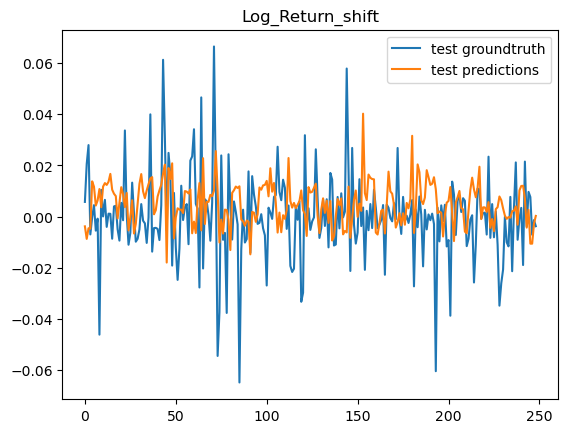

In [54]:
best_model, best_params, best_score, y_pred = train_predict()

Percentage of prediction with correct signal direction: 0.5220883534136547


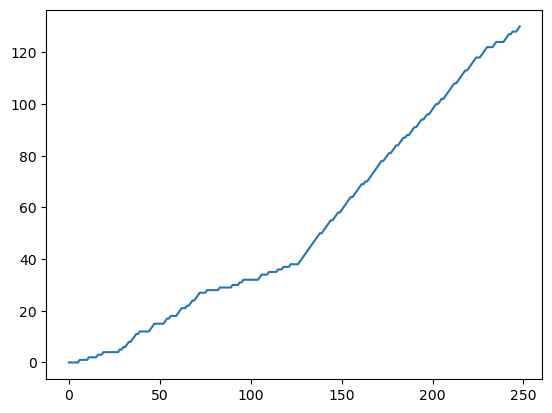

In [55]:
output = []
cumsum = []
for i, v in enumerate(y_pred):
    output.append((y_test[i], y_pred[i]))

output.sort()

total_correct = 0
for x, y in output:
    total_correct += x * y >= 0
    cumsum.append(total_correct)

pct_correct_direction = cumsum[-1] / len(output)
print(f"Percentage of prediction with correct signal direction: {pct_correct_direction}")
plt.plot(cumsum)